In [27]:
# load modules
import pickle, pdb, os, random, yaml, random, math, torch, math
from collections import OrderedDict
import numpy as np
import torch.nn as nn
from data_loader import get_loader, pathSpecDataset
from torch.utils.data import DataLoader
from vte_model import Vt_Embedder
import matplotlib.pyplot as plt

In [2]:

results_dir = '/homes/bdoc3/phonDet/results'
spmel_path = '/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized'
model_name = 'newStandardAutovcSpmelParamsUnnormLatent64Out256'
model_path = os.path.join(results_dir, model_name)
config = pickle.load(open(model_path +'/config_params.pkl','rb'))
config.spmel_dir = config.data_dir

with open(spmel_path +'/spmel_params.yaml') as File:
    spmel_params = yaml.load(File, Loader=yaml.FullLoader)
    
emb_ckpt = model_path +'/best_epoch_checkpoint.pth.tar'

device = torch.device(f'cuda:{config.which_cuda}' if torch.cuda.is_available() else 'cpu')

config

Namespace(batch_size=128, chunk_num=6, chunk_seconds=0.5, ckpt_freq=100, config_file='', cuda=True, data_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', dropout=0.0, epochs=100, file_name='newStandardAutovcSpmelParamsUnnormLatent64Out256', is_blstm=True, iteration=1, load_ckpt='', lr=0.0001, lstm_num=2, model='choi_k2c2', n_mels=96, no_cuda=False, reg=0, seed=1, short=False, spmel_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', test_list='m2_ m10_ m3_ f2_ f4_', use_attention=False, which_cuda=0)

In [3]:
# run model
vte =  Vt_Embedder(config, spmel_params)
for param in vte.parameters():
    param.requires_grad = False
vte_optimizer = torch.optim.Adam(vte.parameters(), 0.0001)
vte_checkpoint = torch.load(emb_ckpt)
new_state_dict = OrderedDict()
for i, (key, val) in enumerate(vte_checkpoint['model_state_dict'].items()):
#     if key.startswith('class_layer'):
#         continue
    new_state_dict[key] = val
vte.load_state_dict(new_state_dict)

for state in vte_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda(which_cuda)

vte.to(device)
vte.eval()

# prep dataset
vocalSet = pathSpecDataset(config, spmel_params)
vocalSet_loader = DataLoader(vocalSet, batch_size=config.batch_size, shuffle=True, drop_last=False)

In [4]:
# infer embeddings
example_data = []
for i in range(5):
    try:
        x_real, style_idx, singer_idx = next(data_iter)
    except:
        data_iter = iter(vocalSet_loader)
        x_real, style_idx, singer_idx = next(data_iter)
    x_real = x_real.to(device)

    x_real_chunked = x_real.view(x_real.shape[0]*config.chunk_num, x_real.shape[1]//config.chunk_num, -1)
    pred_style_idx, all_tensors = vte(x_real_chunked)
    for j in range(len(x_real)):
        # last entry in example_data is a list of all embeddings for that example
        example_data.append((x_real[j], style_idx[j], singer_idx[j], pred_style_idx[j], [embs[j] for embs in all_tensors]))
    print(i)
embs = []
for i in range(len(example_data)):
    emb = example_data[i][-1][-1]
    embs_matrix = tensor_to_matrix(emb)
    embs.append(embs_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
6

In [23]:
def tensor_to_matrix(array)
    embs_mat = np.asmatrix(array.to('cpu'))
    sqr = int(math.sqrt(embs_mat.shape[1]))
    embs_mat = embs_mat.reshape((sqr,sqr))
    return embs_mats

(16, 16)

In [25]:
type(embs_mat)

numpy.matrix

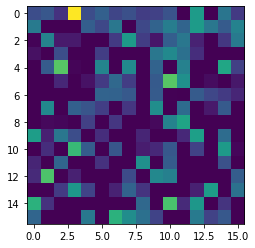

In [28]:
# visualize data
for i in range(1):
    plt.figure()
    plt.imshow(embs_mat)

In [32]:
type(embs_array)

numpy.ndarray

In [31]:
from sklearn.cluster import KMeans

# set up k_means clustering
k_range = range(1,15)
embs_array = np.asarray(embs)

sum_squared_error = []
for k_dim in k_range:    
    km = KMeans(n_clusters=k_dim)
    km.fit_predict(embs_array)
#    print(km.cluster_centers_.shape, km.cluster_centers_) 
    sum_squared_error.append(km.inertia_)
#        print(sum_squared_error) 
plt.plot(k_range, sum_squared_error, label=grouped_dissim_ratings_labels[idx])

ValueError: only one element tensors can be converted to Python scalars

In [7]:
# do clustering